# Customer Churn Prediction Report 

Xueqian Zhang | Candidate for Master of Information System Management-Business Intelligence and Data Analytics at Carnegie Mellon University  
Email: xueqianz@andrew.cmu.edu  
Mobile: 412-623-9657  
Linkedin: https://www.linkedin.com/in/xueqian-zhang/  

## Table of Contents
1. [Introduction](#intro)  
    1.1 [Objectives](#obj)  
    1.2 [Load Dataset](#ld)  
    1.3 [Preprocessing Data](#pd)  
2. [Exploratory Data Analysis](#eda)  
    2.1 [Distribution of Each Feature](#dist)  
    2.2 [Correlation between features](#cor)  
3. [Machine Learning Approach](#ml)  
    3.1 [Feature Selection](#fs)  
    3.2 [Split data into training data and testing data](#split)  
    3.3 [Establishing a Baseline](#baseline)  
    3.4 [Logistics Regression](#lr)  
    3.5 [Random Forest](#rf)  
4. [Model Interpretation](#mi)  
    4.1 [Feature Importances](#fi)  
    4.2 [Visualizing a single decision tree](#v)  
5. [Conclusions](#conclude)  
    
    

<a id = "intro"></a>
## 1 Introduction

In this report, I present findings from an exploration of the telecommunications firm customer dataset which measures 11 variables related to churn for 20,000 customers. Our primary interest is predicting whether the customer leaves, which is often used as a measure of the overall performance of a telecommunications firm.

<a id = "obj"></a>
### 1.1 Objectives


* Identify predictors within the dataset for the customer churn
* Build classification models that can predict the customer churn given the customer data
* Interpret the results of the model and use the trained model to predict churn probability of customers.
* Suggest retention activities that can be taken against target customers.

<a id = "ld"></a>
### 1.2 Load Dataset


In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

In [91]:
data = pd.read_csv('churn.csv')

In [92]:
data.head(5)

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,LEAVE
0,zero,31953,0,6,313378,161,0,4,unsat,little,no,STAY
1,one,36147,0,13,800586,244,0,6,unsat,little,considering,STAY
2,one,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,STAY
3,zero,120070,38,33,788235,780,3,2,unsat,very_high,considering,LEAVE
4,one,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,STAY


In [93]:
data.describe()

,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,80281.447750,85.979550,23.898650,493155.264250,389.615100,8.000700,6.002250
std,41680.586319,85.992324,26.816645,252407.884692,213.820682,8.925418,4.402558
min,20007.000000,-2.000000,0.000000,150002.000000,130.000000,0.000000,1.000000
25%,42217.000000,0.000000,0.000000,263714.250000,219.000000,1.000000,2.000000
50%,75366.500000,59.000000,14.000000,452259.500000,326.000000,4.000000,5.000000
75%,115881.750000,179.000000,41.000000,702378.000000,533.250000,15.000000,10.000000
max,159983.000000,335.000000,89.000000,999996.000000,899.000000,29.000000,15.000000


<a id = "pd"></a>
### 1.3 Preprocessing Data


In [94]:
# Null information
data.isnull().sum()

COLLEGE                        0
INCOME                         0
OVERAGE                        0
LEFTOVER                       0
HOUSE                          0
HANDSET_PRICE                  0
OVER_15MINS_CALLS_PER_MONTH    0
AVERAGE_CALL_DURATION          0
REPORTED_SATISFACTION          0
REPORTED_USAGE_LEVEL           0
CONSIDERING_CHANGE_OF_PLAN     0
LEAVE                          0
dtype: int64

In [95]:
for column in data.columns:
    uniques = sorted(data[column].unique())
    print('{0:30s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

COLLEGE                            2	 ['one', 'zero']
INCOME                         18541	 [20007, 20009, 20012, 20013, 20015]
OVERAGE                          284	 [-2, 0, 3, 7, 10]
LEFTOVER                          86	 [0, 5, 6, 7, 8]
HOUSE                          19703	 [150002, 150015, 150021, 150027, 150066]
HANDSET_PRICE                    770	 [130, 131, 132, 133, 134]
OVER_15MINS_CALLS_PER_MONTH       25	 [0, 1, 3, 4, 5]
AVERAGE_CALL_DURATION             13	 [1, 2, 4, 5, 6]
REPORTED_SATISFACTION              5	 ['avg', 'sat', 'unsat', 'very_sat', 'very_unsat']
REPORTED_USAGE_LEVEL               5	 ['avg', 'high', 'little', 'very_high', 'very_little']
CONSIDERING_CHANGE_OF_PLAN         5	 ['actively_looking_into_it', 'considering', 'never_thought', 'no', 'perhaps']
LEAVE                              2	 ['LEAVE', 'STAY']


In [96]:
# data for EDA
data_c = data.copy()

replace_map_leave = {'LEAVE': {'LEAVE': 1, 'STAY': 0}}
data_c.replace(replace_map_leave, inplace=True)

# Typecast categorical features to a category dtype to get faster operation
data_c['COLLEGE'] = data_c['COLLEGE'].astype('category')
data_c['REPORTED_SATISFACTION'] = data_c['REPORTED_SATISFACTION'].astype('category')
data_c['REPORTED_USAGE_LEVEL'] = data_c['REPORTED_USAGE_LEVEL'].astype('category')
data_c['CONSIDERING_CHANGE_OF_PLAN'] = data_c['CONSIDERING_CHANGE_OF_PLAN'].astype('category')

In [97]:
# data for modeling
data_replace = data.copy()
replace_map = {'COLLEGE': {'one':1,'zero':0},
               'REPORTED_SATISFACTION': {'very_unsat': 1, 'unsat': 2, 'avg': 3, 'sat': 4,'very_sat': 5},
               'REPORTED_USAGE_LEVEL': {'very_little': 1, 'little': 2, 'avg': 3, 'high': 4,'very_high': 5},
               'CONSIDERING_CHANGE_OF_PLAN': {'never_thought': 1, 'no': 2, 'perhaps': 3, 'considering': 4,'actively_looking_into_it': 5},
               'LEAVE': {'LEAVE': 1, 'STAY': 0}}
data_replace.replace(replace_map, inplace=True)

In [98]:
# Check balanced data
leave_percentage = data_replace['LEAVE'].sum()/data_replace['LEAVE'].count()
print('Percentage of leave observations on all data: '+ str(leave_percentage*100) + '%')

Percentage of leave observations on all data: 49.26%


There are 20,000 customers in the dataset with 11 features each. There is no missing values and the dataset is a balanced dataset. I also convert ordinal and categorical data from text to numerical value for modeling convenience.

<a id = "eda"></a>
## 2. Exploratory Data Analysis


In order to determine if certain features will affect customer churn,we can first take a look at the relationship between features by looking at the Pearson coefficients and choose features that are more correlated wtih our target LEAVE.Then we can get a better understanding of those features by ploting the distribution of each by whether the customer leaves. 

<a id = "cor"></a>
### Correlation between features

This following plot shows the correlation between LEAVE and 11 different customer features. For all customers we see the following relationships:

* 'Overage' and 'Over_15_mins_call_per_month' are positively correlated with 'leave'

* 'House' is negatively correlated  with 'leave'  <br/>

* 'Income' and 'Handset_price' are highly positively correlated

* 'Overage' and 'Over_15_mins_call_per_month' are highly positively correlated

* 'Leftover' and 'Average_call_duration' are highly negatively correlated<br/> 

Some features are not correlated with out ob

There is multi-collinearity problem. <br/> 

However, for logistics regression, regularization can fix the multicollinearity problem by down-weighting the features that are not important. And for the random forest, multi-collinearity will not be a problem (I use logistics regression and random forest to predict churn later). So, we do not need to remove collinear features at this point.

Zero indicates that two features are not correlated, larger than zero mean positive correlated, smaller than zero mean negtive correlated.


In [113]:
corr = data_replace.corr()
corr

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,LEAVE
COLLEGE,1.000000,0.011122,-0.003091,-0.003925,-0.000217,0.009950,-0.007205,-0.001490,0.003058,-0.000240,-0.011841,0.014673
INCOME,0.011122,1.000000,0.000458,0.006515,-0.010964,0.727200,0.002136,-0.007219,-0.002459,0.001459,-0.002229,0.096320
OVERAGE,-0.003091,0.000458,1.000000,-0.003123,0.002412,0.000324,0.770557,0.000653,-0.019057,-0.000568,0.014073,0.235139
LEFTOVER,-0.003925,0.006515,-0.003123,1.000000,0.006530,0.004004,-0.010411,-0.660285,0.001841,-0.007729,0.013660,0.060540
HOUSE,-0.000217,-0.010964,0.002412,0.006530,1.000000,-0.007756,0.007410,-0.009359,-0.004691,0.005587,-0.008021,-0.211213
HANDSET_PRICE,0.009950,0.727200,0.000324,0.004004,-0.007756,1.000000,0.002680,-0.005190,0.002047,-0.003443,-0.003294,0.089221
OVER_15MINS_CALLS_PER_MONTH,-0.007205,0.002136,0.770557,-0.010411,0.007410,0.002680,1.000000,0.007769,-0.013917,0.001433,0.011653,0.202193
AVERAGE_CALL_DURATION,-0.001490,-0.007219,0.000653,-0.660285,-0.009359,-0.005190,0.007769,1.000000,-0.002380,0.009701,-0.008600,-0.008704
REPORTED_SATISFACTION,0.003058,-0.002459,-0.019057,0.001841,-0.004691,0.002047,-0.013917,-0.002380,1.000000,0.000386,-0.008511,-0.012105
REPORTED_USAGE_LEVEL,-0.000240,0.001459,-0.000568,-0.007729,0.005587,-0.003443,0.001433,0.009701,0.000386,1.000000,-0.004340,0.001199


### Correlation Heatmap

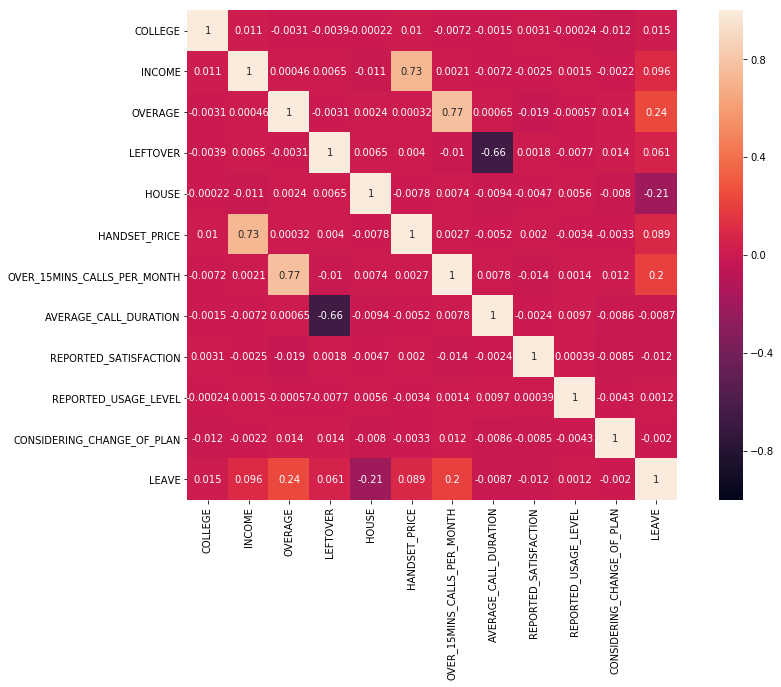

In [114]:
a = plt.subplots(figsize=(15,9))
a = sns.heatmap(corr, vmin=-1, vmax=1 , annot=True , square=True)

<a id = "dist"></a>
### Feature 1: COLLEGE

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


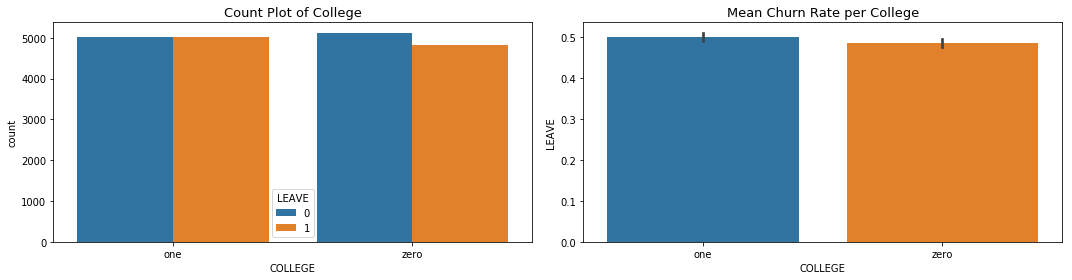

In [99]:
# Visualization of different COLLEGE
grouped = data_c[['COLLEGE', 'LEAVE']].groupby('COLLEGE').mean().reset_index()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
sns.countplot(x='COLLEGE', hue='LEAVE', data=data_c, ax=ax[0])
ax[0].set_title('Count Plot of College', fontsize=13)
sns.barplot(x='COLLEGE', y='LEAVE', data=data_c, ax=ax[1])
ax[1].set_title('Mean Churn Rate per College', fontsize=13)
plt.tight_layout()
plt.show()

* The churn rate of customers who are college educated and who are not are roughly the same.

### Feature 2: REPORTED_SATISFACTION

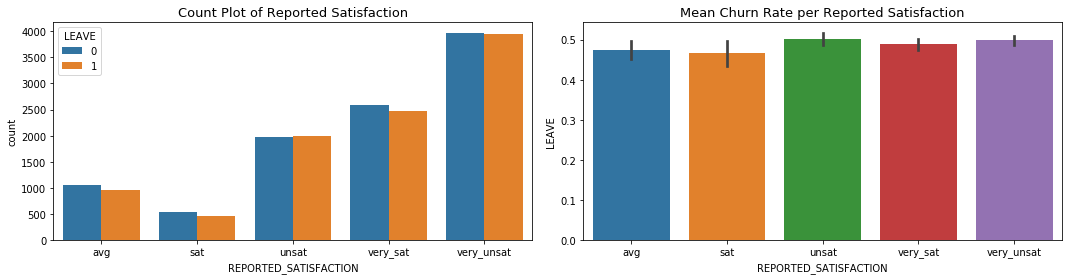

In [100]:
# Visualization of different REPORTED_SATISFACTION
grouped = data_c[['REPORTED_SATISFACTION', 'LEAVE']].groupby('REPORTED_SATISFACTION').mean().reset_index()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
sns.countplot(x='REPORTED_SATISFACTION', hue='LEAVE', data=data_c, ax=ax[0])
ax[0].set_title('Count Plot of Reported Satisfaction', fontsize=13)
sns.barplot(x='REPORTED_SATISFACTION', y='LEAVE', data=data_c, ax=ax[1])
ax[1].set_title('Mean Churn Rate per Reported Satisfaction', fontsize=13)
plt.tight_layout()
plt.show()

In [101]:
very_unsat_rate = (data_c['REPORTED_SATISFACTION']==('very_unsat')).mean()
unsat_rate = (data_c['REPORTED_SATISFACTION']==('unsat')).mean()
unsat_and_very_unsat_rate = very_unsat_rate + unsat_rate
print('Total unsatisfied and very unsatisfied rate: ' + str(unsat_and_very_unsat_rate*100)+'%')
print('Unsatisfied rate: ' + str(unsat_rate*100)+'%')
print('Very unsatisfied rate: ' + str(very_unsat_rate*100)+'%')

Total unsatisfied and very unsatisfied rate: 59.5%
Unsatisfied rate: 19.955000000000002%
Very unsatisfied rate: 39.545%


* The churn rate for customers of different reported satisfaction levels are roughly the same. 
* However, there are 59.5% of customers who report unsatisfied or very unsatisfied about the service. 

### Feature 3: REPORTED_USAGE_LEVEL

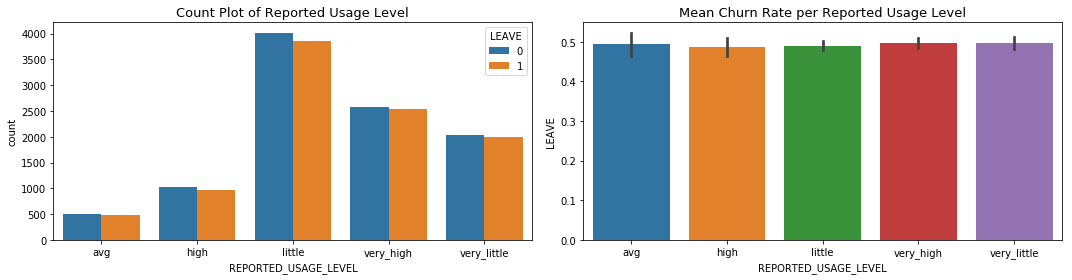

In [102]:
# Visualization of different REPORTED_USAGE_LEVEL
grouped = data_c[['REPORTED_USAGE_LEVEL', 'LEAVE']].groupby('REPORTED_USAGE_LEVEL').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
sns.countplot(x='REPORTED_USAGE_LEVEL', hue='LEAVE', data=data_c, ax=ax[0])
ax[0].set_title('Count Plot of Reported Usage Level', fontsize=13)
sns.barplot(x='REPORTED_USAGE_LEVEL', y='LEAVE', data=data_c, ax=ax[1])
ax[1].set_title('Mean Churn Rate per Reported Usage Level', fontsize=13)
plt.tight_layout()
plt.show()

In [103]:
little_usage_level = (data_c['REPORTED_USAGE_LEVEL']==('little')).mean()
very_little_usage_level = (data_c['REPORTED_USAGE_LEVEL']==('very_little')).mean()
very_little_and_little = very_little_usage_level+little_usage_level
print('Very little and little usage level propotion: ' + str(np.round(very_little_and_little*100,2))+'%')
print('Very little rate: ' + str(np.round(very_little_usage_level*100,2))+'%')
print('Little rate: ' + str(np.round(little_usage_level*100,2))+'%')

Very little and little usage level propotion: 59.48%
Very little rate: 20.1%
Little rate: 39.38%


* The churn rate for customers of different reported usage levels are roughly the same. 
* However, there are 59.48% of customers who report very little or little usage of the service. 

### Feature 4: CONSIDERING_CHANGE_OF_PLAN

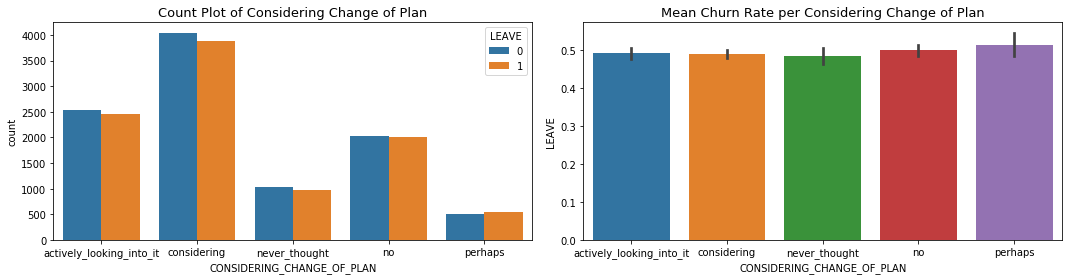

In [104]:
 # Visualization of different CONSIDERING_CHANGE_OF_PLAN
grouped = data_c[['CONSIDERING_CHANGE_OF_PLAN', 'LEAVE']].groupby('CONSIDERING_CHANGE_OF_PLAN').mean().reset_index()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
sns.countplot(x='CONSIDERING_CHANGE_OF_PLAN', hue='LEAVE', data=data_c, ax=ax[0])
ax[0].set_title('Count Plot of Considering Change of Plan', fontsize=13)
sns.barplot(x='CONSIDERING_CHANGE_OF_PLAN', y='LEAVE', data=data_c, ax=ax[1])
ax[1].set_title('Mean Churn Rate per Considering Change of Plan', fontsize=13)
plt.tight_layout()
plt.show()

In [105]:
actively_looking_rate = (data_c['CONSIDERING_CHANGE_OF_PLAN']==('actively_looking_into_it')).mean()
considering_rate = (data_c['CONSIDERING_CHANGE_OF_PLAN']==('considering')).mean()
total = considering_rate + actively_looking_rate
print('Total considering change of plan rate: ' + str(np.round(total*100,2))+'%')
print('Actively looking rate: ' + str(np.round(actively_looking_rate*100,2))+'%')
print('Considering rate: ' + str(np.round(considering_rate*100,2))+'%')

Total considering change of plan rate: 64.57%
Actively looking rate: 24.97%
Considering rate: 39.6%


* The churn rate for customers of different considering change of plan levels are roughly the same. 
* However, there are 64.57% of customers who report actively looking into change of plan or considering change of plan. 

### Feature 5: INCOME 

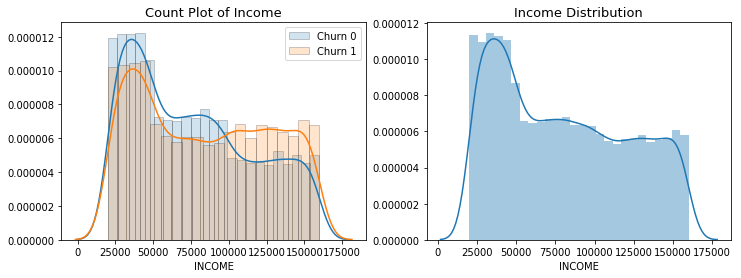

In [106]:
# Visualization of INCOME 
grouped = data_c[['INCOME', 'LEAVE']].groupby('INCOME').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.distplot(data_c[data_c['LEAVE'] == 0]['INCOME'], label='Churn 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data_c[data_c['LEAVE'] == 1]['INCOME'], label='Churn 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Income', fontsize=13)
ax[0].legend()
sns.distplot(data_c['INCOME'])
ax[1].set_title('Income Distribution', fontsize=13)
ax[1].set_xlabel('INCOME')
plt.show()

* The churn rate of customers whoes income are larger than 100000 are higher. 

### Feature 6: HOUSE 

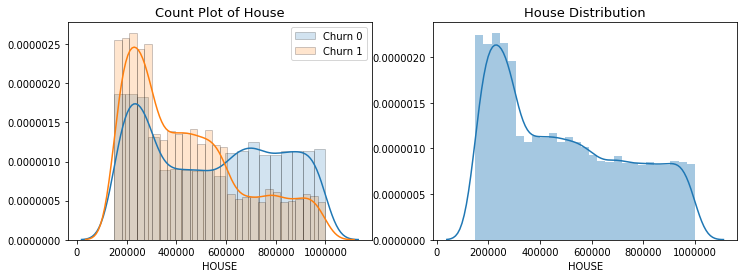

In [107]:
# Visualization of HOUSE 
grouped = data_c[['HOUSE', 'LEAVE']].groupby('HOUSE').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.distplot(data_c[data_c['LEAVE'] == 0]['HOUSE'], label='Churn 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data_c[data_c['LEAVE'] == 1]['HOUSE'], label='Churn 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of House', fontsize=13)
ax[0].legend()
sns.distplot(data_c['HOUSE'])
ax[1].set_title('House Distribution', fontsize=13)
ax[1].set_xlabel('HOUSE')
plt.show()

* The churn rate of customer whoes house value are smaller than 600000 are higher.

### Feature 7: HANDSET_PRICE

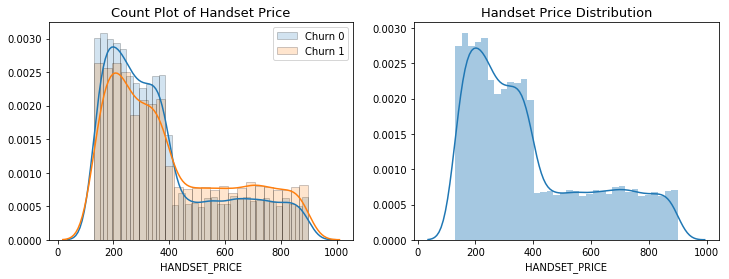

In [108]:
# Visualization of HANDSET_PRICE 
grouped = data_c[['HANDSET_PRICE', 'LEAVE']].groupby('HANDSET_PRICE').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.distplot(data_c[data_c['LEAVE'] == 0]['HANDSET_PRICE'], label='Churn 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data_c[data_c['LEAVE'] == 1]['HANDSET_PRICE'], label='Churn 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Handset Price', fontsize=13)
ax[0].legend()
sns.distplot(data_c['HANDSET_PRICE'])
ax[1].set_title('Handset Price Distribution', fontsize=13)
ax[1].set_xlabel('HANDSET_PRICE')
plt.show()

* The churn rate of customer whoes handset price are larger than 400 are higher.

### Feature 8: OVER_15MINS_CALLS_PER_MONTH

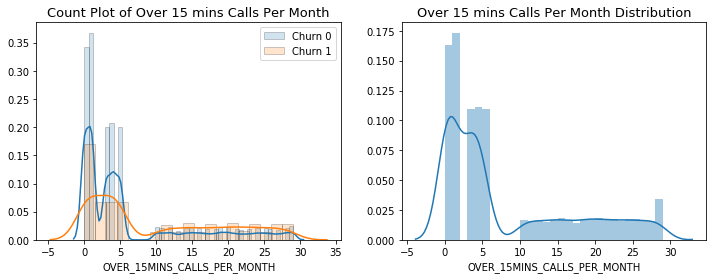

In [109]:
# Visualization of OVER_15MINS_CALLS_PER_MONTH 
grouped = data_c[['OVER_15MINS_CALLS_PER_MONTH', 'LEAVE']].groupby('OVER_15MINS_CALLS_PER_MONTH').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.distplot(data_c[data_c['LEAVE'] == 0]['OVER_15MINS_CALLS_PER_MONTH'], label='Churn 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data_c[data_c['LEAVE'] == 1]['OVER_15MINS_CALLS_PER_MONTH'], label='Churn 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Over 15 mins Calls Per Month', fontsize=13)
ax[0].legend()
sns.distplot(data_c['OVER_15MINS_CALLS_PER_MONTH'])
ax[1].set_title('Over 15 mins Calls Per Month Distribution', fontsize=13)
ax[1].set_xlabel('OVER_15MINS_CALLS_PER_MONTH')
plt.show()

* The churn rate of customer who have more than 10 over 15 mins calls per month are higher.

### Feature 9: AVERAGE_CALL_DURATION

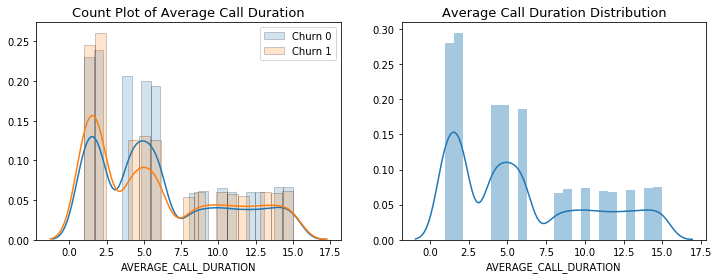

In [110]:
# Visualization of AVERAGE_CALL_DURATION
grouped = data_c[['AVERAGE_CALL_DURATION', 'LEAVE']].groupby('AVERAGE_CALL_DURATION').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.distplot(data_c[data_c['LEAVE'] == 0]['AVERAGE_CALL_DURATION'], label='Churn 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data_c[data_c['LEAVE'] == 1]['AVERAGE_CALL_DURATION'], label='Churn 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Average Call Duration', fontsize=13)
ax[0].legend()
sns.distplot(data_c['AVERAGE_CALL_DURATION'])
ax[1].set_title('Average Call Duration Distribution', fontsize=13)
ax[1].set_xlabel('AVERAGE_CALL_DURATION')
plt.show()

* The churn rate of customers who have 0-2.5 average call duration are higher.

### Feature 10: OVERAGE

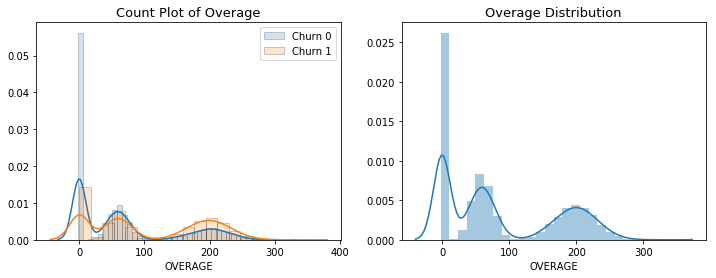

In [111]:
# Visualization of OVERAGE
grouped = data_c[['OVERAGE', 'LEAVE']].groupby('OVERAGE').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.distplot(data_c[data_c['LEAVE'] == 0]['OVERAGE'], label='Churn 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data_c[data_c['LEAVE'] == 1]['OVERAGE'], label='Churn 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Overage', fontsize=13)
ax[0].legend()
sns.distplot(data_c['OVERAGE'])
ax[1].set_title('Overage Distribution', fontsize=13)
ax[1].set_xlabel('OVERAGE')
plt.show()

* The churn rate of customers who have more than 120 overage are higher.

### Feature 11: LEFTOVER

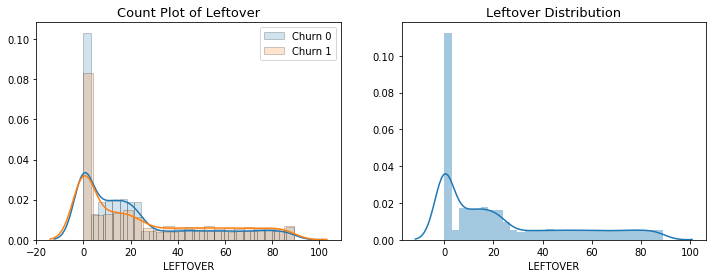

In [112]:
# Visualization of LEFTOVER
grouped = data_c[['LEFTOVER', 'LEAVE']].groupby('LEFTOVER').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.distplot(data_c[data_c['LEAVE'] == 0]['LEFTOVER'], label='Churn 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data_c[data_c['LEAVE'] == 1]['LEFTOVER'], label='Churn 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Leftover', fontsize=13)
ax[0].legend()
sns.distplot(data_c['LEFTOVER'])
ax[1].set_title('Leftover Distribution', fontsize=13)
ax[1].set_xlabel('LEFTOVER')
plt.show()

* The churn rate of customers who have different leftover are roughly the same. 

<a id = "ml"></a>
## 3. Machine Learning Approach

The objective is to predict the customer churn given the variables available in

the data. First, I will do feature selection to keep features that are most helpful for the prediction and then I will split the data into  70% training and 30% testing set.  

For modeling, I will first establish a baseline classifier and then try two different models to predict customer churn:

1. Logistics Regression:   

• Metrics: Accuracy 

2. Random Forest  

• Metrics: Accuracy 



I will use grid search to find out the best hyperparameters for each model and use accuracy to evaluate the two models.

<a id = "fs"></a>
### 3.1 Feature Selection

According to EDA, we can find out that COLLEGE, REPORTED_SATISFACTION, REPORTED_USAGE_LEVEL, and CONSIDERING_CHANGE_OF_PLAN do not correlate with LEAVE too much. So I will drop these features. 

In [115]:
feature_cols = ['INCOME','OVERAGE','LEFTOVER','HOUSE','HANDSET_PRICE','OVER_15MINS_CALLS_PER_MONTH','AVERAGE_CALL_DURATION']

<a id = "split"></a>
### 3.2 Split data into training data and testing data

In [116]:
X = data_replace[feature_cols].values
y = data_replace['LEAVE'].values

In [117]:
from sklearn.model_selection import train_test_split
# Split into 70% training and 30% testing set
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3,random_state = 42)

<a id = "baseline"></a>
### 3.3 Establishing a Baseline

Use majority vote as the naive baseline.

In [118]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

clf = DummyClassifier(strategy= 'most_frequent')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
y_true = y_test
print('Accuracy of the baseline model: '+ str(np.round(accuracy_score(y_true, y_pred),2)))

Accuracy of the baseline model: 0.51


<a id = "lr"></a>
### 3.4 Logistics Regression

Logistics regression is extremely straightforward and produces explainable results. It is a good method to start with, but if the problem is not linear, then our model will not be very useful.

I also perform a grid search over the parameters listed below for a Logisitic Regression classifier, using accuracy for scoring and 5-fold cross validation.

'penalty': ['l1', 'l2']

'C':[0.01, 0.1, 1, 10, 100]

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

## Define the grid of logistic regression parameters
parameters = {'penalty':['l1', 'l2'], 'C':[0.01, 0.1, 1, 10, 100]}
model = LogisticRegression(solver = 'liblinear')
    
## Perform grid search CV to find best model parameter setting
cmodel = GridSearchCV(model, param_grid=parameters,scoring = 'accuracy',cv =5)
cmodel.fit(X_train, y_train)

## Fit logistic regression with best parameters to the entire training data
model = LogisticRegression(penalty=cmodel.best_estimator_.get_params()['penalty'],C=cmodel.best_estimator_.get_params()['C'],solver = 'liblinear')
model.fit(X_train, y_train)
    
logR_test_pred = model.predict(X_test)

## Measure test accuracy
logR_test_acc = model.score(X_test, y_test)

print('Logistic classifier accuray:', np.round(logR_test_acc,2))


Logistic classifier accuray: 0.64


 The accuracy of logistic classifier increases to 0.64 compared with the baseline model 0.51, but it still does not perform well. So I will move on to more serious machine learning models-- random forest.

<a id = "rf"></a>
### 3.5 Random Forest

Next, I implement a random forest classifier. The random forest is more interpretable because it returns feature importances which we can use to compare the most helpful variables for making predictions. The random forest is generally very accurate and performs well on non-linear problems.

I also perform a grid search over the parameters listed below for a Random Forest classifier, using accuracy for scoring and 5-fold cross validation.
* 'n_estimators': [100, 150, 200,250]
* 'max_depth':[2,3,4,5]

In [120]:
from sklearn.ensemble import RandomForestClassifier

## Define the grid of Random Forest parameters
parameters = {'n_estimators':[100, 150, 200,250], 'max_depth':[2,3,4,5]}
model = RandomForestClassifier()

## Perform grid search CV to find best model parameter setting
cmodel = GridSearchCV(model, param_grid=parameters,scoring = 'accuracy',cv =5)
cmodel.fit(X_train, y_train)

## Fit Random Forest classifier with best parameters to the entire training data
model = RandomForestClassifier(n_estimators=cmodel.best_estimator_.get_params()['n_estimators'],
                               max_depth=cmodel.best_estimator_.get_params()['max_depth'],random_state=42)
model.fit(X_train, y_train)
    
RF_test_pred = model.predict(X_test)

## Measure test accuracy
RF_test_acc = model.score(X_test, y_test)

print('Random Forest classifier accuray:', np.round(RF_test_acc,2))


Random Forest classifier accuray: 0.69


The accuracy of random forest classifier increases to 0.693 compared with the logistics regression classifier 0.64 and baseline model 0.51. Thus, we can select the random forest classifier as our model to predict customers churn.

<a id = "mi"></a>
## 4. Model Interpretation

<a id = "fi"></a>
### 4.1 Feature Importances

I use feature importances to show the relevance of each feature to the task of predicting the churn. 

In [121]:
# model is the Random Forest classifier with best parameters
importances = model.feature_importances_

# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': feature_cols, 
                                'importance': importances})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', 
                                              ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,HOUSE,0.359226
1,OVERAGE,0.230134
2,OVER_15MINS_CALLS_PER_MONTH,0.125794
3,INCOME,0.104953
4,LEFTOVER,0.073452
5,HANDSET_PRICE,0.056883
6,AVERAGE_CALL_DURATION,0.049559


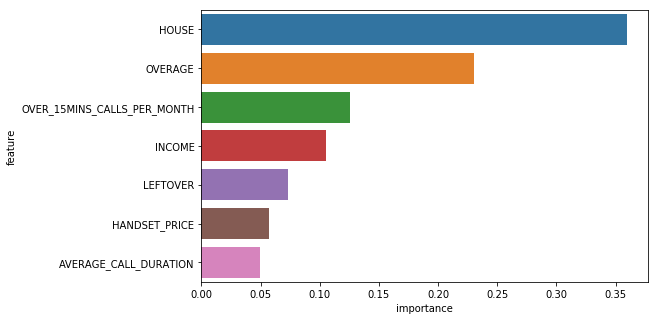

In [122]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='importance', y='feature', data=feature_results)
plt.show()

The HOUSE and the OVERAGE are by far the most important features, accounting for about 60% of the total importance. After the top two features, OVER_15MINS_CALLS_PER_MONTH and INCOME accounting for about 23% of the total importance. After the top four features, the importance drops off significantly, which indicates that these features are not very relevant with our target - churn prediction.

Based on these results, we can conclude that the most important indicators of whether a customer will churn are the HOUSE and the OVERAGE. 

<a id = "v"></a>
### 4.2 Visualizing a single decision tree

We can visualize a decision tree from the random forest to get a more intuitive understanding of the random forest model we build.

In [123]:
# Clase_name: 
# 0 - 'STAY'
# 1 - 'LEAVE'
class_names=['STAY', 'LEAVE']

In [124]:
from sklearn import tree

# Extract a single tree (number 50)
single_tree = model.estimators_[50]

# Save the tree to a dot file
tree.export_graphviz(single_tree, out_file = 'tree_limited.dot', max_depth=2,
                     feature_names = feature_cols,class_names = class_names)

In [125]:
!dot -Tpng tree_limited.dot -o tree_limited.png -Gdpi=600

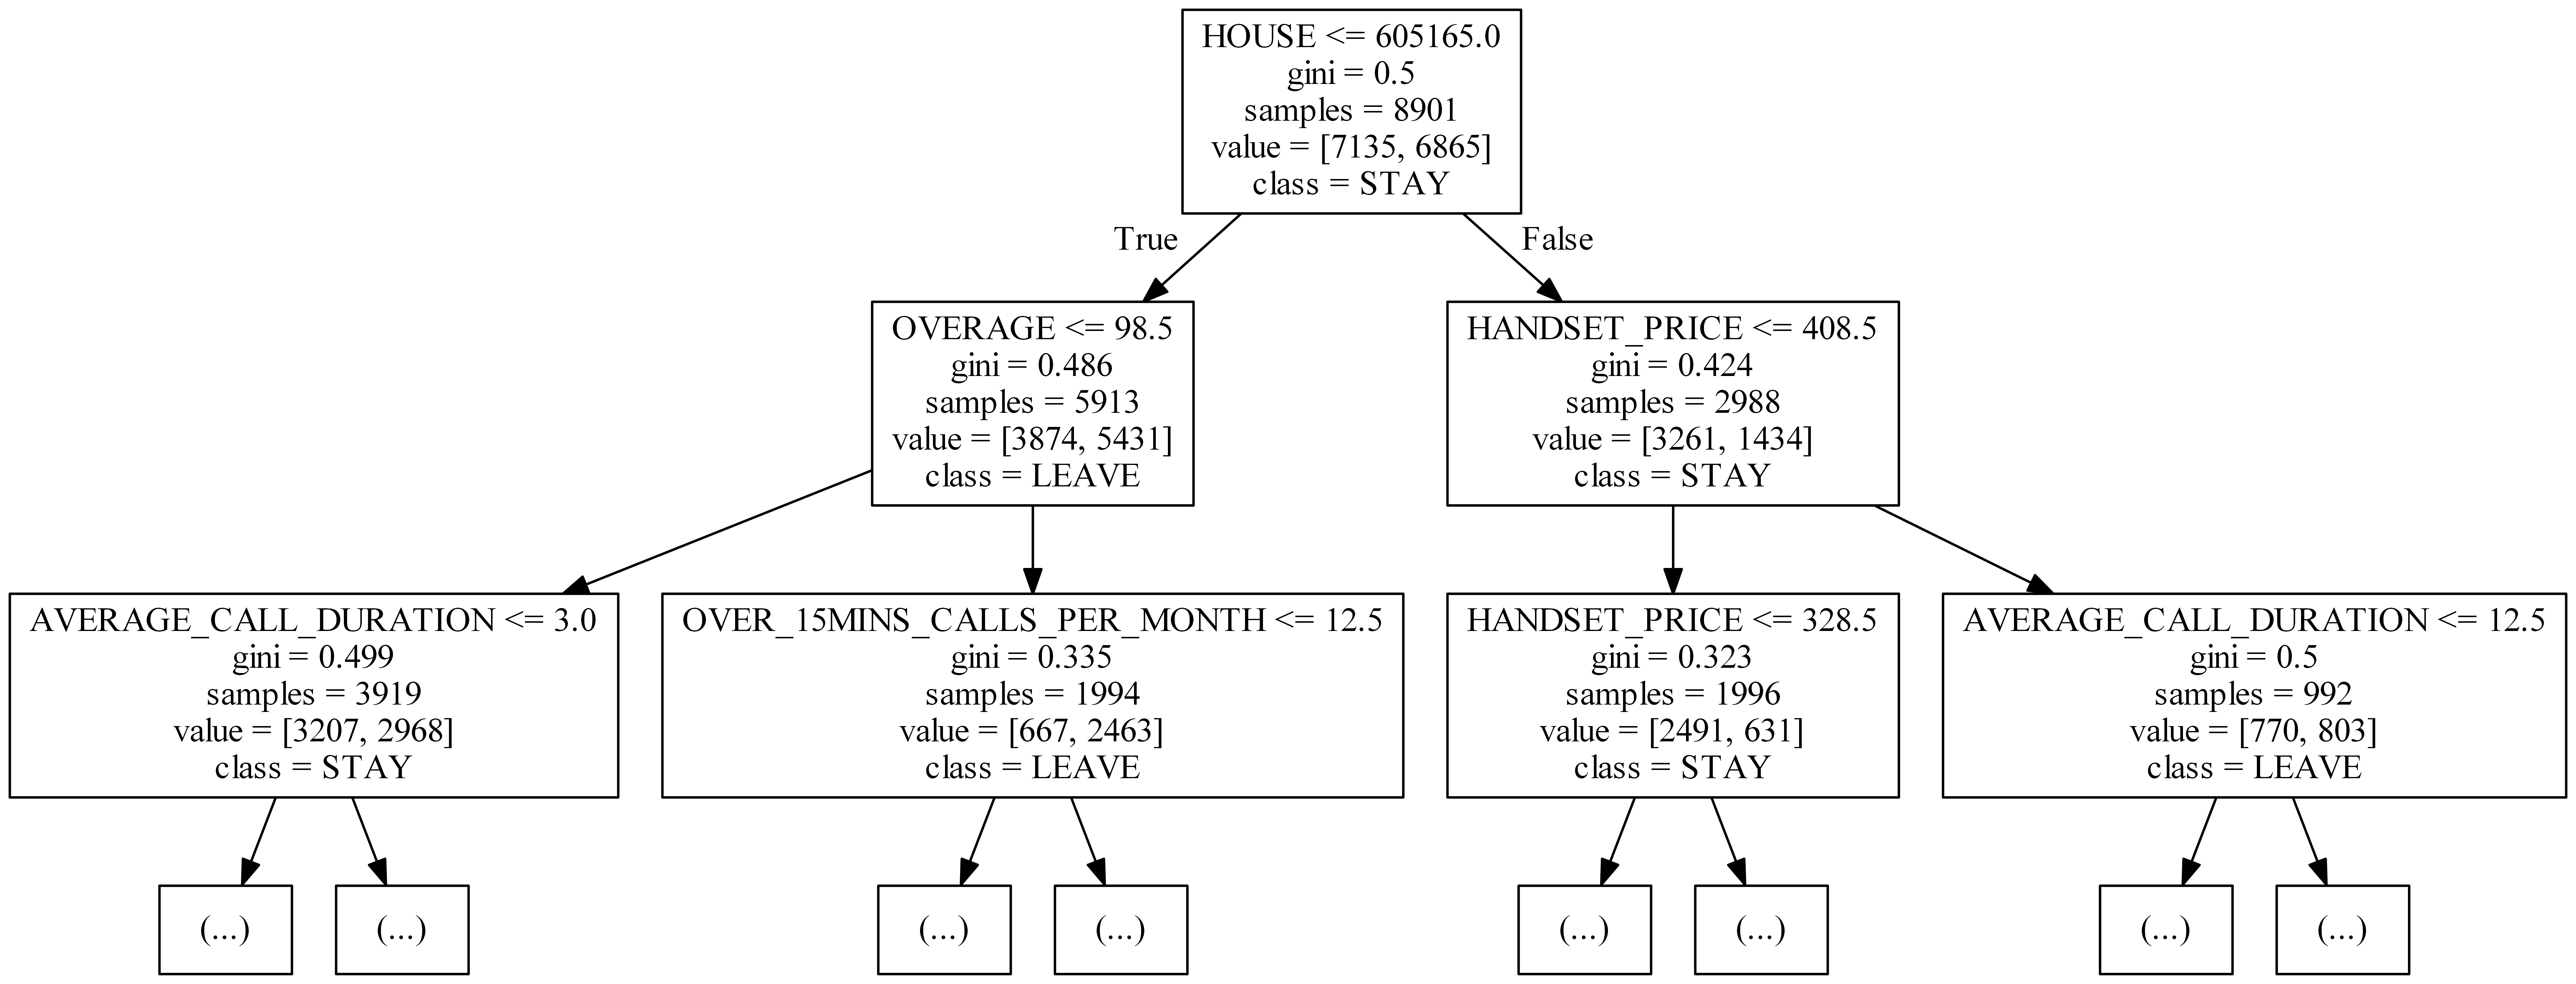

In [126]:
from IPython.display import Image
Image(filename = 'tree_limited.png')

Each node in the tree has four pieces of information:



* The question asked about the value of one feature of the data point: this determines if we go right or left out of the node;

* The Gini: a measure of the impurity of a data partition of the node;

* The samples: the number of examples in the node;

* The class: the estimate of the target for all the samples in the node.

Although we cannot examine every tree in the model, looking at one lets us understand how each individual learner makes a prediction. For example, in the tree we visualize above:

* The question for the top first node is: Does the customer have a house values less than or equal to 605165? If yes, the customer is placed in the right child node, and if the answer is no, the customer goes to the left child node. This process is repeated at each layer of the tree until the data point is placed in a leaf node, at the bottom of the tree.

* If a customer has a house value less than or equal to 605165 and overage more than 98.5, we predict that the customer will leave.

* If a customer has a house value larger than 605165 and handset price more than 408.5, we predict that the customer will leave.

<a id = "conclude"></a>
## 5. Conclusions

Given the exploration in this notebook, I can conclude that we can create a model to accurately predict customer churn given the customer data, and we have determined that the HOUSE, the OVERAGE, the OVER_15MINS_CALLS_PER_MONTH, and the INCOME are the four most useful factors for determining the customer churn.

The highlights from the report are:

1. A random forest classifier trained on the training data was able to achieve an accuracy of 69% on testing dataset, which was significantly better than the baseline measure and logistics regression model.

2. The HOUSE and the OVERAGE are the two most important features, accounting for about 60% of the total feature importance for churn prediction. After the top two features, OVER_15MINS_CALLS_PER_MONTH and INCOME accounting for about 23% of the total importance.

3. HOUSE is negatively correlated with LEAVE, and OVERAGE, OVER_15MINS_CALLS_PER_MONTH and INCOME are positively correlated with LEAVE.

4. Although reported satisfaction levels and considering change of plan level are not an important features for churn prediction, there are 59.5% of customers who report unsatisfied or very unsatisfied about the service and 64.57% of customers who report actively looking into change of plan or considering change of plan. We might want to dig deeper into the reason of why customers are unsatisfied and want to change plan, which might be a future work.

Suggestions on retention activity:  

1. Combine the fact that OVERAGE is an important feature and positively correlated with churn, we can suggest the telecommunications firm launch new plan such as unlimited data plan for customers who have high overage and are likely to leave.

2. For customer who has low house value and is likely to leave, since the logic between HOUSE and LEAVE are not very intuitively, we can suggest the telecommunications firm to college more data and find out why low house value customer is more likely to churn and launch retention activity accordingly.  